<a href="https://colab.research.google.com/github/darshanvjani/ERA_vision_nlp_ai/blob/main/Building%20the%20First%20Neural%20Network/Corrected_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [5]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [6]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [7]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 84929159.66it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36009421.47it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26485389.52it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2925000.58it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

In [8]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

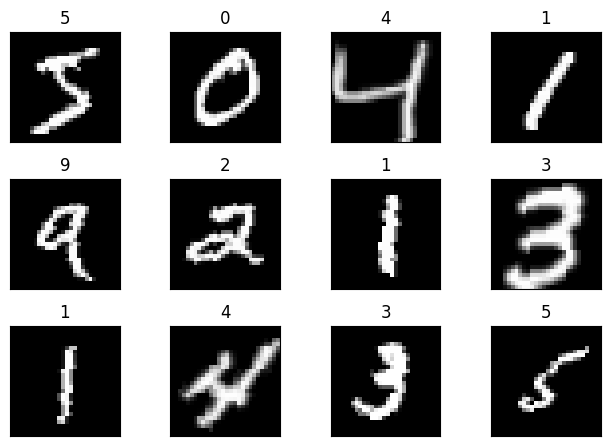

In [9]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [14]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2) #28>26 | 1>3 | 1
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  #26>24>12 | 3>5>6 | 1>1>2
        x = F.relu(self.conv3(x), 2) #12>10 | 6>10 | 2>2
        x = F.relu(F.max_pool2d(self.conv4(x), 2))  #10>8>4 | 10>14>16 | 2>2>4
        x = x.view(-1, 4096) #4*4*256 == 4096
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [15]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


CODE BLOCK: 8

In [16]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [17]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [21]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.6609 Batch_id=117 Accuracy=39.89: 100%|██████████| 118/118 [00:24<00:00,  4.76it/s]


Test set: Average loss: 0.3763, Accuracy: 8837/10000 (88.37%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.2724 Batch_id=117 Accuracy=92.28: 100%|██████████| 118/118 [00:23<00:00,  4.98it/s]


Test set: Average loss: 0.0995, Accuracy: 9676/10000 (96.76%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.2887 Batch_id=117 Accuracy=95.88: 100%|██████████| 118/118 [00:23<00:00,  5.13it/s]


Test set: Average loss: 0.0692, Accuracy: 9774/10000 (97.74%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.2016 Batch_id=117 Accuracy=96.88: 100%|██████████| 118/118 [00:24<00:00,  4.89it/s]


Test set: Average loss: 0.0544, Accuracy: 9822/10000 (98.22%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.1855 Batch_id=117 Accuracy=97.26: 100%|██████████| 118/118 [00:22<00:00,  5.16it/s]


Test set: Average loss: 0.0602, Accuracy: 9811/10000 (98.11%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.1594 Batch_id=117 Accuracy=97.58: 100%|██████████| 118/118 [00:22<00:00,  5.14it/s]


Test set: Average loss: 0.0506, Accuracy: 9837/10000 (98.37%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.1644 Batch_id=117 Accuracy=97.86: 100%|██████████| 118/118 [00:23<00:00,  5.09it/s]


Test set: Average loss: 0.0410, Accuracy: 9872/10000 (98.72%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.1214 Batch_id=117 Accuracy=97.96: 100%|██████████| 118/118 [00:23<00:00,  5.02it/s]


Test set: Average loss: 0.0444, Accuracy: 9863/10000 (98.63%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.1229 Batch_id=117 Accuracy=98.29: 100%|██████████| 118/118 [00:23<00:00,  5.05it/s]


Test set: Average loss: 0.0346, Accuracy: 9888/10000 (98.88%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.1273 Batch_id=117 Accuracy=98.47: 100%|██████████| 118/118 [00:23<00:00,  5.02it/s]


Test set: Average loss: 0.0315, Accuracy: 9893/10000 (98.93%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.1378 Batch_id=117 Accuracy=98.37: 100%|██████████| 118/118 [00:23<00:00,  5.05it/s]


Test set: Average loss: 0.0295, Accuracy: 9899/10000 (98.99%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0921 Batch_id=117 Accuracy=98.60: 100%|██████████| 118/118 [00:24<00:00,  4.92it/s]


Test set: Average loss: 0.0312, Accuracy: 9900/10000 (99.00%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.1160 Batch_id=117 Accuracy=98.61: 100%|██████████| 118/118 [00:22<00:00,  5.17it/s]


Test set: Average loss: 0.0281, Accuracy: 9908/10000 (99.08%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0706 Batch_id=117 Accuracy=98.60: 100%|██████████| 118/118 [00:22<00:00,  5.16it/s]


Test set: Average loss: 0.0250, Accuracy: 9911/10000 (99.11%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0747 Batch_id=117 Accuracy=98.80: 100%|██████████| 118/118 [00:22<00:00,  5.13it/s]


Test set: Average loss: 0.0258, Accuracy: 9918/10000 (99.18%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0587 Batch_id=117 Accuracy=99.02: 100%|██████████| 118/118 [00:23<00:00,  5.10it/s]


Test set: Average loss: 0.0217, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0562 Batch_id=117 Accuracy=99.07: 100%|██████████| 118/118 [00:23<00:00,  5.04it/s]


Test set: Average loss: 0.0214, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0276 Batch_id=117 Accuracy=99.06: 100%|██████████| 118/118 [00:23<00:00,  5.09it/s]


Test set: Average loss: 0.0216, Accuracy: 9921/10000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0396 Batch_id=117 Accuracy=99.10: 100%|██████████| 118/118 [00:23<00:00,  5.09it/s]


Test set: Average loss: 0.0215, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0490 Batch_id=117 Accuracy=99.12: 100%|██████████| 118/118 [00:25<00:00,  4.69it/s]


Test set: Average loss: 0.0213, Accuracy: 9921/10000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

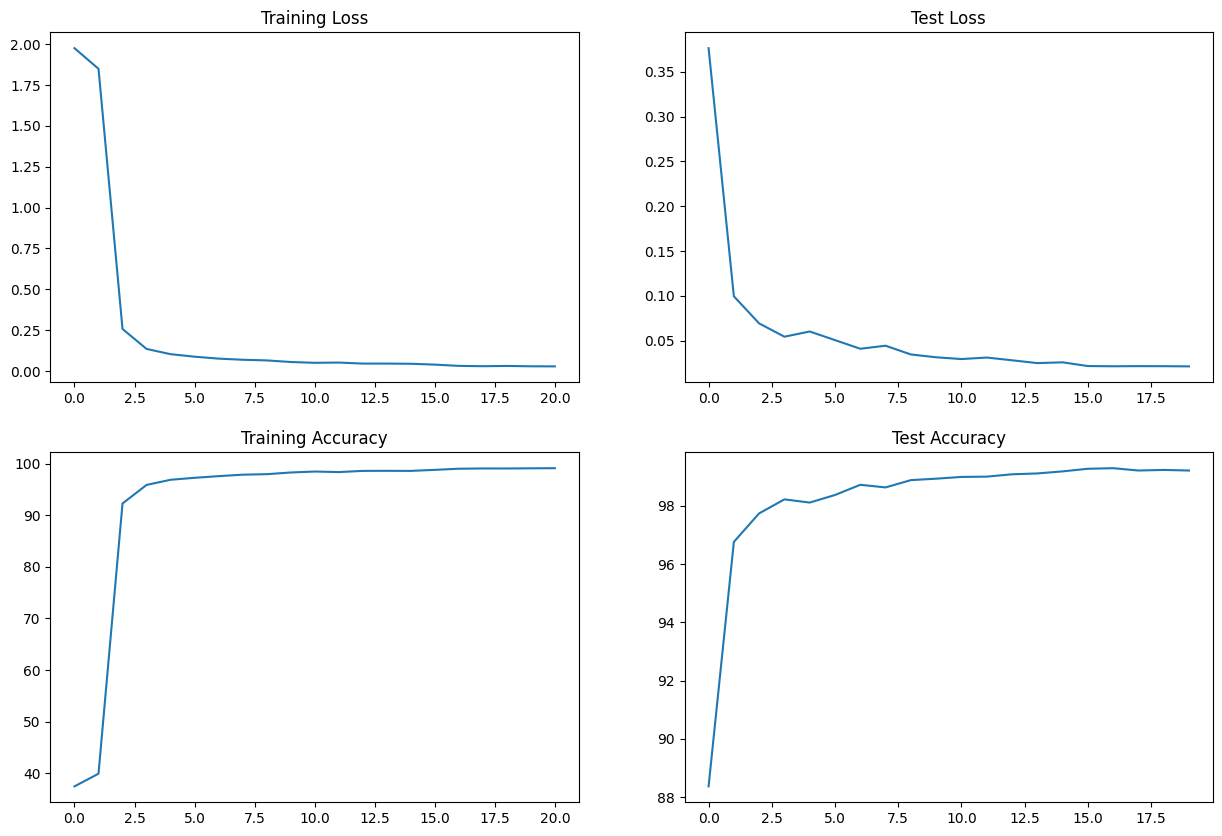

In [22]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")